# Bài 12: SQL (part 2)

ERD: https://sp.postgresqltutorial.com/wp-content/uploads/2018/03/printable-postgresql-sample-database-diagram.pdf

## 0. Set up

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a connection
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="dvdrental",
    user="postgres",
    password="admin123",
    #gssencmode="disable" # Important to fix a bug
)

## 1. GROUP BY
Làm các bài tập dưới, nếu thông tin cột cần dùng chưa có thì dùng ID (chưa cần join)

### Ex1:
- Lọc ra các phim length >= 100, Group phim theo rating, đếm số lượng cho mỗi loại rating, sắp xếp từ cao xuống thấp
- Plot

In [46]:
q = """
select
    rating, 
    rental_duration,
    count(*) as n_rows
from film
where length >= 100
group by rating, rental_duration
order by rating, rental_duration
"""

df = pd.read_sql(q, conn)
df.head(100)

,rating,rental_duration,n_rows
0,G,3,21
1,G,4,15
2,G,5,21
3,G,6,30
4,G,7,17
5,PG,3,24
6,PG,4,21
7,PG,5,21
8,PG,6,20
9,PG,7,30


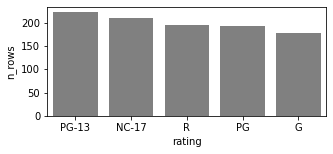

In [20]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.barplot(
    x="rating",
    y="n_rows",
    color="grey",
    ax=ax,
    data=df
)
plt.show()

### Ex2: 
- Như Ex1, nhưng lọc ra những dòng có count >= 200 

### Ex3:
- Tìm ra top 5 khách hàng có tổng payment nhiều nhất
- Plot

In [52]:
q = """
select 
    customer_id,
    sum(amount) as total_amount
from payment
group by customer_id
order by total_amount desc
limit 5
"""
df = pd.read_sql(q, conn)

In [53]:
df.head(3)

,customer_id,total_amount
0,148,211.55
1,526,208.58
2,178,194.61


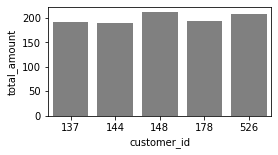

In [55]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(
    x="customer_id",
    y="total_amount",
    color="grey",
    ax=ax,
    data=df
)
plt.show()

### Ex4: 
- Tìm ra staff có tổng doanh số nhiều nhất trong tháng 3
- Tương tự cho cả năm

In [51]:
window = """
partition by date_part('month', payment_date) 
order by sum(amount) desc
"""

q = """
select
        date_part('month', payment_date) as pmt_month,
        staff_id,
        sum(amount) as total_amount,
        dense_rank() over ({}) as rank
    from payment
    group by staff_id, pmt_month
    order by pmt_month, rank
""".format(window)

pd.read_sql(q, conn)

,pmt_month,staff_id,total_amount,rank
0,2.0,2,4191.00,1
1,2.0,1,4160.84,2
2,3.0,2,12109.73,1
3,3.0,1,11776.83,2
4,4.0,2,14479.10,1
5,4.0,1,14080.36,2
6,5.0,2,280.09,1
7,5.0,1,234.09,2


In [29]:
df

,pmt_month,staff_id,amount_mar
0,2.0,1,4160.84
1,2.0,2,4191.00
2,3.0,1,11776.83
3,3.0,2,12109.73
4,4.0,1,14080.36
5,4.0,2,14479.10
6,5.0,1,234.09
7,5.0,2,280.09


In [19]:
df.head(4)

,pmt_month,staff_id,amount_mar
0,2.0,1,4160.84
1,2.0,2,4191.00
2,3.0,1,11776.83
3,3.0,2,12109.73


In [23]:
df2 = df.pivot(index="pmt_month", columns="staff_id", values="amount_mar")
df2.head(2)

staff_id,1,2
pmt_month,,
2.0,4160.84,4191.00
3.0,11776.83,12109.73


In [27]:
df2["max_value"] = df2.max(axis=1)

In [28]:
df2

staff_id,1,2,max_value
pmt_month,,,
2.0,4160.84,4191.00,4191.00
3.0,11776.83,12109.73,12109.73
4.0,14080.36,14479.10,14479.10
5.0,234.09,280.09,280.09


### Ex5:
- Tính tổng số phim cho mỗi category
- Plot

In [57]:
q = """
select 
    category_id,
    count(*) as n_films
from film_category
group by category_id
order by category_id
"""

df = pd.read_sql(q, conn)

In [58]:
df.head(3)

,category_id,n_films
0,1,64
1,2,66
2,3,60


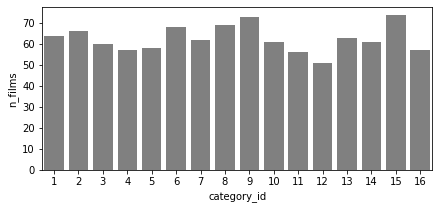

In [61]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.barplot(
    x="category_id",
    y="n_films",
    color="grey",
    ax=ax,
    data=df
)
plt.show()

## 2. Join

#### Ex1:
- Lấy ra title, language ID, language name, rating cho các bộ phim trong có rating là `R`
-  Có phim nào không có thông tin language name

In [84]:
q = """
select 
    title, 
    rating,
    name as language
from film f
left join language l
on f.language_id = l.language_id
where 
    rating = 'R'
limit 3
"""

pd.read_sql(q, conn)

,title,rating,language
0,Grosse Wonderful,R,English
1,Airport Pollock,R,English
2,Date Speed,R,English


### Ex2: 
- Lấy ra title, film ID, category ID, category name, rating cho các bộ phim trong có rating là `R`
- Có phim nào ko có category name?

In [101]:
q = """
select 
    title,
    c.name as category,
    f.rating
from film f
left join film_category fc
on f.film_id = fc.film_id
inner join category c
on fc.category_id = c.category_id
where rating = 'R'
limit 3
"""

pd.read_sql(q, conn)

,count
0,195


### Ex3:
- Lấy ra title, film ID, actor ID, actor full name, rating cho các bộ phim trong có rating là `R`

In [108]:
q = """
select
    a.actor_id,
    (a.first_name || ' ' || a.last_name) as full_name,
    count(*) as n_films
from film f
left join film_actor fa
on f.film_id = fa.film_id
left join actor a
on fa.actor_id = a.actor_id
group by a.actor_id, a.first_name || ' ' || a.last_name
order by n_films desc
limit 5
"""

pd.read_sql(q, conn)

,actor_id,full_name,n_films
0,107,Gina Degeneres,42
1,102,Walter Torn,41
2,198,Mary Keitel,40
3,181,Matthew Carrey,39
4,23,Sandra Kilmer,37


### Ex4:
- Lấy thông tin khách hàng gồm: id, names, email, phone, address (full)


In [119]:
q = """
select
    country,
    count(*) as n_cust
from customer c
left join address a
on c.address_id = a.address_id
left join city c1
on a.city_id = c1.city_id
left join country c2
on c1.country_id = c2.country_id
group by country
order by n_cust desc
limit 5
"""

pd.read_sql(q, conn)

,country,n_cust
0,India,60
1,China,53
2,United States,36
3,Japan,31
4,Mexico,30


## Ex6: 
- Làm lại các bài tập trong phần group by (lấy thêm thông tin nhờ join)

In [123]:
# Tim ra top 5 khach hang co payment nhieu nhat co ten
q = """
select
    c.customer_id, first_name, last_name,
    sum(amount) as total_amount
from customer c
left join payment p
on c.customer_id = p.customer_id
group by c.customer_id, first_name, last_name
order by total_amount asc
limit 5
"""

pd.read_sql(q, conn)

,customer_id,first_name,last_name,total_amount
0,318,Brian,Wyman,27.93
1,281,Leona,Obrien,32.90
2,248,Caroline,Bowman,37.87
3,320,Anthony,Schwab,47.85
4,110,Tiffany,Jordan,49.88


## 3. Các VD khác (kiến thức tổng hợp)

### Ex1:
- Tìm các bộ phim đã thuê chưa trả

In [ ]:
title, rental_date, return_date

In [7]:
q = """
select
    i.film_id, title,
    rental_date, return_date
from rental r 
left join inventory i
on r.inventory_id = i.inventory_id
left join film f
on i.film_id = f.film_id
where return_date is null
"""

pd.read_sql(q, conn)

,count
0,183


## Ex2: 
- Tìm ra các bộ phim đã trễ hạn
- Các bộ phim này nằm ở inventory nào
- Các bộ phim này do ai thuê
- Các bộ phim này thuộc category nào

In [11]:
q = """select max(rental_date) from rental"""
pd.read_sql(q, conn)

,max
0,2006-02-14 15:16:03


In [13]:
run_date = "2006-02-15"

In [40]:
q = """
select
   c.name as category,
   count(*) as n_films
from rental r
left join inventory i
on r.inventory_id = i.inventory_id
left join film f
on i.film_id = f.film_id
left join film_category fc
on f.film_id = fc.film_id
left join category c
on fc.category_id = c.category_id
where 
    (date_part('day', r.return_date - r.rental_date) > rental_duration)
    or (
        (rental_date is null) and 
        (date_part('day', now() - r.rental_date) > rental_duration)
    )
    
group by c.category_id, c.name
order by n_films desc
"""

pd.read_sql(q, conn)

,category,n_films
0,Sports,529
1,Sci-Fi,484
2,Animation,452
3,Documentary,449
4,Action,449
5,New,424
6,Family,411
7,Drama,403
8,Comedy,396
9,Games,396


In [26]:
q = """
select
    distinct i.inventory_id
from rental r
left join inventory i
on r.inventory_id = i.inventory_id
left join film f
on i.film_id = f.film_id
where 
    (date_part('day', r.return_date - r.rental_date) > rental_duration)
    or (date_part('day', now() - r.rental_date) > rental_duration)
"""

pd.read_sql(q, conn)

,inventory_id
0,1489
1,273
2,3936
3,2574
4,951
...,...
4575,55
4576,3858
4577,790
4578,3984


### Ex3
- Các bộ phim được thuê trong khoảng thời gian nào
- Tìm ra top 5 film có doanh thu nhiều nhất vào tháng 2 nam 2006 (có plot)
- Tương tự làm cho tất cả các tháng trong năm

In [64]:
q = """
select 
    f.film_id, title,
    sum(amount) as total_amount
from rental r
left join payment p
on p.rental_id = r.rental_id
left join inventory i
on r.inventory_id = i.inventory_id
left join film f
on i.film_id = f.film_id
where 
    rental_date >= '2006-02-01'
    and rental_date < '2006-03-01'
group by f.film_id, title
order by total_amount desc
limit 5
"""

df = pd.read_sql(q, conn)

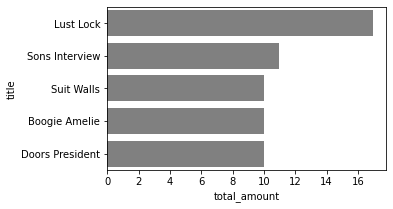

In [70]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(
    y="title",
    x="total_amount",
    data=df,
    color="grey",
    orient="h",
    ax=ax
)
plt.show()

In [94]:
window = """
partition by date_part('month', rental_date)
order by sum(amount) desc
"""

q = """
select *
from (
    select 
        date_part('month', rental_date) as month,
        f.film_id, title,
        sum(case when amount is null then 0 else amount end) as total_amount,
        rank() over ({}) as ranking
    from rental r
    left join payment p
    on p.rental_id = r.rental_id
    left join inventory i
    on r.inventory_id = i.inventory_id
    left join film f
    on i.film_id = f.film_id
    where 
        rental_date >= '2005-07-01'
        and rental_date < '2006-01-01'
    group by month, f.film_id, title
    order by month, total_amount desc
) as temp
where ranking <= 3

""".format(window)

pd.read_sql(q, conn)

,month,film_id,title,total_amount,ranking
0,7.0,764,Saturday Lambs,103.87,1
1,7.0,460,Innocent Usual,98.87,2
2,7.0,893,Titans Jerk,97.86,3
3,8.0,973,Wife Turn,94.89,1
4,8.0,244,Dorado Notting,90.87,2
5,8.0,444,Hustler Party,84.90,3


In [97]:
q = """
select 
    title, 
    length,
    (case
        when length < 50 then 'short'
        when length < 100 then 'medium'
        else 'long'
    end) as length_type
from film
limit 10
"""

pd.read_sql(q, conn)

,title,length,length_type
0,Chamber Italian,117,long
1,Grosse Wonderful,49,short
2,Airport Pollock,54,medium
3,Bright Encounters,73,medium
4,Academy Dinosaur,86,medium
5,Ace Goldfinger,48,short
6,Adaptation Holes,50,medium
7,Affair Prejudice,117,long
8,African Egg,130,long
9,Agent Truman,169,long


### Ex4
- Tìm ra top 5 nhân viên có doanh thu nhiều nhất vào tháng 1  (có plot)
- Tương tự làm cho tất cả các tháng trong năm

In [103]:
q = """
select 
    p.staff_id, first_name, last_name,
    sum(case when amount is null then 0 else amount end) as total_amount
from rental r
left join payment p
on r.rental_id = p.rental_id
left join staff s
on p.staff_id = s.staff_id
group by p.staff_id, first_name, last_name
"""
pd.read_sql(q, conn)

,staff_id,first_name,last_name,total_amount
0,NaN,None,None,0.00
1,2.0,Jon,Stephens,31059.92
2,1.0,Mike,Hillyer,30252.12


### Ex5: 
- Có bao nhiêu nhân viên
- Tạo bảng doanh số từng tháng cho các nhân viên theo dạng sau

```
+---------------------------+
| month | staff_1 | staff_2 |
+---------------------------+
|     1 |         |         |
|     2 |         |         |
|     3 |         |         |
.............................
|    12 |         |         |
+---------------------------+
```
- Vẽ plot biểu thị doanh số cho 2 nhân viên

In [ ]:
2020-01-02

In [19]:
q = """
select
    substring(cast(payment_date as text), 1, 7) as ym,
    staff_id, 
    sum(amount) as monthly_amount
from payment
group by ym, staff_id
order by ym, staff_id
"""

df = pd.read_sql(q, conn)

In [20]:
df.head()

,ym,staff_id,monthly_amount
0,2007-02,1,4160.84
1,2007-02,2,4191.00
2,2007-03,1,11776.83
3,2007-03,2,12109.73
4,2007-04,1,14080.36


In [23]:
df2 = df.pivot(index="ym", columns="staff_id", values="monthly_amount")

In [26]:
df2

staff_id,1,2
ym,,
2007-02,4160.84,4191.00
2007-03,11776.83,12109.73
2007-04,14080.36,14479.10
2007-05,234.09,280.09


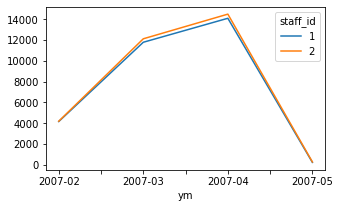

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
df2.plot.line(ax=ax)
plt.show()

In [31]:
df["staff_id"] = pd.Categorical(df["staff_id"])

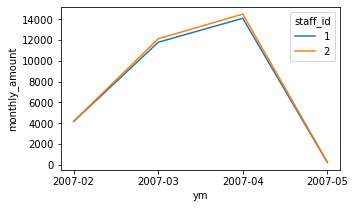

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    x="ym",
    y="monthly_amount",
    hue="staff_id",
    ax=ax,
    data=df
)
plt.show()

### Ex6: 
- Top 5 diễn viên có phim được bán chạy nhất trong năm (plot)
- Mỗi diễn viên trong top 5 trên đóng bao nhiêu bộ
- Plot diễn viên và số bộ phim đã đóng

In [42]:
q = """
select 
    a.actor_id,
    (a.first_name || ' ' || a.last_name) as full_name,
    sum(p.amount) as total_amount
from payment p
left join rental r
on p.rental_id = r.rental_id
left join inventory i
on r.inventory_id = i.inventory_id
left join film f
on i.film_id = f.film_id
left join film_actor fa
on f.film_id = fa.film_id
left join actor a
on fa.actor_id = a.actor_id
group by a.actor_id, full_name
order by total_amount desc
limit 5
"""

df = pd.read_sql(q, conn)

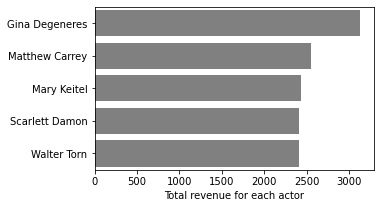

In [51]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(
    x="total_amount",
    y="full_name",
    ax=ax,
    data=df,
    orient="h",
    color="grey"
)

plt.show()

In [53]:
top5_actor_ids = df["actor_id"].tolist()

In [54]:
top5_actor_ids

[107, 181, 198, 81, 102]

In [71]:
top5_str = ",".join([str(x) for x in top5_actor_ids])

q = """
select 
    (a.first_name || ' ' || a.last_name) as full_name,
    count(*) as n_films
from actor a
left join film_actor fa
on a.actor_id = fa.actor_id
left join film f
on fa.film_id = f.film_id
where a.actor_id in ({})
group by full_name
""".format(top5_str)

# print(q)
df2 = pd.read_sql(q, conn)

In [72]:
df2

,full_name,n_films
0,Mary Keitel,40
1,Walter Torn,41
2,Gina Degeneres,42
3,Scarlett Damon,36
4,Matthew Carrey,39


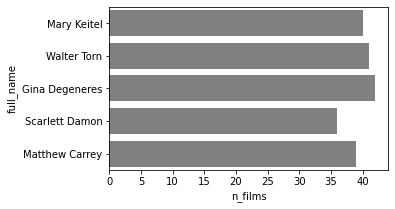

In [74]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(
    x="n_films",
    y="full_name",
    ax=ax,
    data=df2,
    orient="h",
    color="grey"
)

plt.show()

### Ex7: 
- Khách hàng đến từ những nước nào
- Doanh số theo từng nước (cao -> thấp) (có plot)

In [85]:
q = """
select
    country,
    sum(amount) as total_amount    
from payment p
left join customer c
on p.customer_id = c.customer_id
left join address a
on c.address_id = a.address_id
left join city c1
on a.city_id = c1.city_id
left join country c2
on c1.country_id = c2.country_id
group by country
order by total_amount desc
limit 20
"""

df = pd.read_sql(q, conn)

In [86]:
df.head(3)

,country,total_amount
0,India,6034.78
1,China,5251.03
2,United States,3685.31


In [95]:
df


,country,total_amount
0,India,6034.78
1,China,5251.03
2,United States,3685.31
3,Japan,3122.51
4,Mexico,2984.82
5,Brazil,2919.19
6,Russian Federation,2765.62
7,Philippines,2219.70
8,Turkey,1498.49
9,Indonesia,1352.69


In [100]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [116]:
plt.style.use("seaborn-whitegrid")

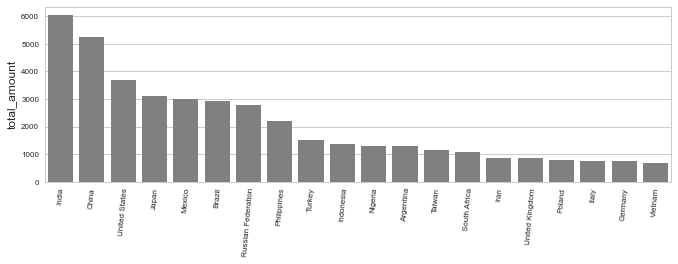

In [118]:

fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(
    x="country",
    y="total_amount",
    color="grey",
    data=df,
    ax=ax
)

ax.set_xticklabels(df["country"].tolist(), rotation=85)
ax.set_xlabel(None)
plt.show()